# Buried valley investigation using HVSR acquisition

this code is based on hvsrpy, a Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing, developed by Joseph P. Vantassel with contributions from Dana M. Brannon under the supervision of Professor Brady R. Cox at The University of Texas at Austin.

-Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo. http://doi.org/10.5281/zenodo.3666956

# Libraries import and data input

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

file_loc = "input"
output = "output"
file_name = "Colico_p1.SAF" #ascii file name
#file_name = "Colico_p2.SAF" #ascii file name
#file_name = "Colico_p3.SAF" #ascii file name
#file_name = "Colico_p4.SAF" #ascii file name
#file_name = "Colico_p5.SAF" #ascii file name
#file_name = "Colico_p6.SAF" #ascii file name
#file_name = "Colico_p7.SAF" #ascii file name
#file_name = "Colico_p8.SAF" #ascii file name

file_data = os.path.join(file_loc, file_name)

# Target area image

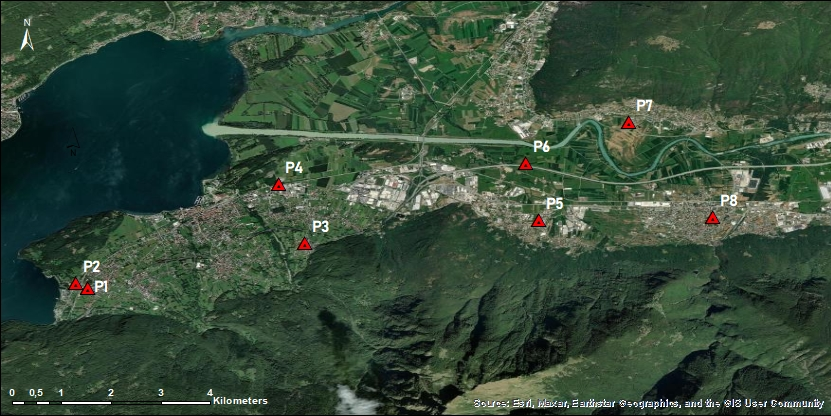

In [3]:
from IPython.display import Image
import matplotlib.image as image 

Image("Colico.jpg",width=1000)

# Useful acquisition information display

In [4]:
lines2print = [0,1,12,13,14,15,16,19,20,21,23,24,26,27,29,32]  
with open(file_data, 'r') as ff:
    [print(x.strip()) for ei,x in enumerate(ff) if ei in lines2print] #Visualizzazione delle stringhe di interesse del file ASCII

with open(file_data, 'r') as ff:
    y = [line.strip() for line in ff]
    z = y[0] #Estrazione station name
    nm = z.split()[2]

STN_NAME = p1
SESAME ASCII data format (saf) v. 1
LAT = 46.1228848
LON = 9.3515516
NDAT = 450000
SAMP_FREQ = 500.0
UNITS = mm/s
CH0_ID = UD
CH1_ID = NS
CH2_ID = EW
SENSOR_TYPE = Triaxial Geophone
SENSOR_NAME = GEMINI-2
SENS_EIGFREQ = 2.0
SENS_DAMPING = 0.70
ACQ_SYSTEM = GEMINI 3D Land Geophone
START_TIME = 2024 06 03 16 15 01


# ASCII file reading and subdivision in the three component of motion

In [5]:
data_df = pd.read_csv(file_data, skiprows=43, names= ['Z', 'R', 'T'], sep='\s+', dtype={'Z': np.float64, "R": np.float64, "T": np.float64})

# Raw data plotting

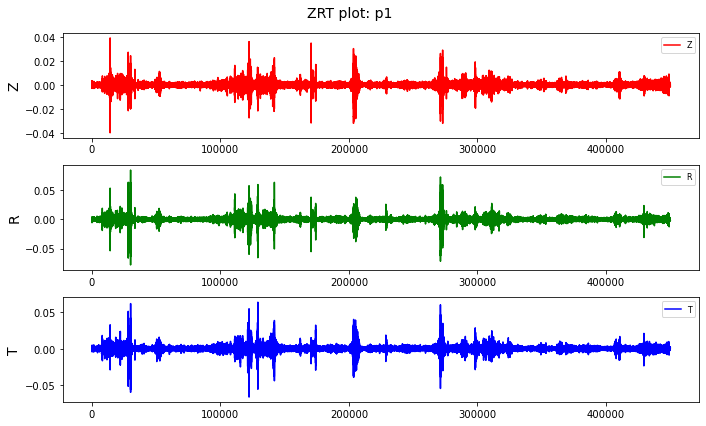

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,6))

ax1.plot(data_df['Z'], color="r", label="Z")
ax1.set_ylabel("Z", fontsize=14)
ax1.legend(fontsize=8, frameon=True)

plt.suptitle(f"ZRT plot: {nm}", fontsize=14)


ax2.plot(data_df['R'], color="g", label="R")
ax2.set_ylabel("R", fontsize=14)
ax2.legend(fontsize=8, frameon=True)


ax3.plot(data_df['T'], color="b", label="T")
ax3.set_ylabel("T", fontsize=14)
ax3.legend(fontsize=8, frameon=True)

plt.tight_layout()


plt.savefig(os.path.join(output, f"{nm}_ZRT.png"),
    bbox_inches="tight",
    dpi=300,)

# Hvsrpy libraries import

In [7]:
import time

import hvsrpy
from hvsrpy import utils

import sigpropy

# Allowing the code to read an ASCII file instead of an MSEED one

In [8]:
with open(file_data, "r") as f:
    lines = f.readlines()
    
for idx, line in enumerate(lines):
    if line.startswith("SAMP_FREQ = "):
        fs = float(line[len("SAMP_FREQ = "):])
    if line.startswith("####--------"):
        idx += 1
        break

vt = []
ns = []
ew = []
for line in lines[idx:]:
    _vt, _ns, _ew = line.split()
    vt.append(_vt)
    ns.append(_ns)
    ew.append(_ew)

vt = sigpropy.TimeSeries(vt, dt=1/fs)
ns = sigpropy.TimeSeries(ns, dt=1/fs)
ew = sigpropy.TimeSeries(ew, dt=1/fs)
    
sensor = hvsrpy.Sensor3c(ns, ew, vt)

# HVSR parameters input

In [9]:
windowlength = 60

# Boolean to control whether Butterworth filter is applied. 
filter_bool = False       
# Low-cut frequency for bandpass filter.
filter_flow = 0.1                   
# High-cut frequency for bandpass filter.
filter_fhigh = 30                   
# Filter order.
filter_order = 5

# Width of cosine taper {0. - 1.}
width = 0.1

# Konno and Ohmachi smoothing constant.
bandwidth = 40

# Minimum frequency after resampling
resample_fmin = 0.1  
# Maximum frequency after resampling
resample_fmax = 50
# Number of frequencies after resampling
resample_fnum = 200
# Type of resampling {'log', 'linear'}
resample_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None

# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
method = "geometric-mean"
# Variable for azimuth anisotropy calculation
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
rejection_bool = True
# Number of standard deviations to consider during rejection. 
n = 2
# Maximum number of iterations to perform for rejection
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. 
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. 
distribution_mc = "lognormal"

# ylimits of the HVSR figures. 
ymin, ymax = 0, 10

# HVSR curve plot

Elapsed Time: 0.63 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.57                          1.87
Fundamental Site Period, T0                 1.76                          1.87


Analysis summary:


Window length                                    60s
No. of windows                                    14
Number of iterations to convergence  2 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.28                          0.66
Fundamental Site Period, T0                 3.51                          0.66

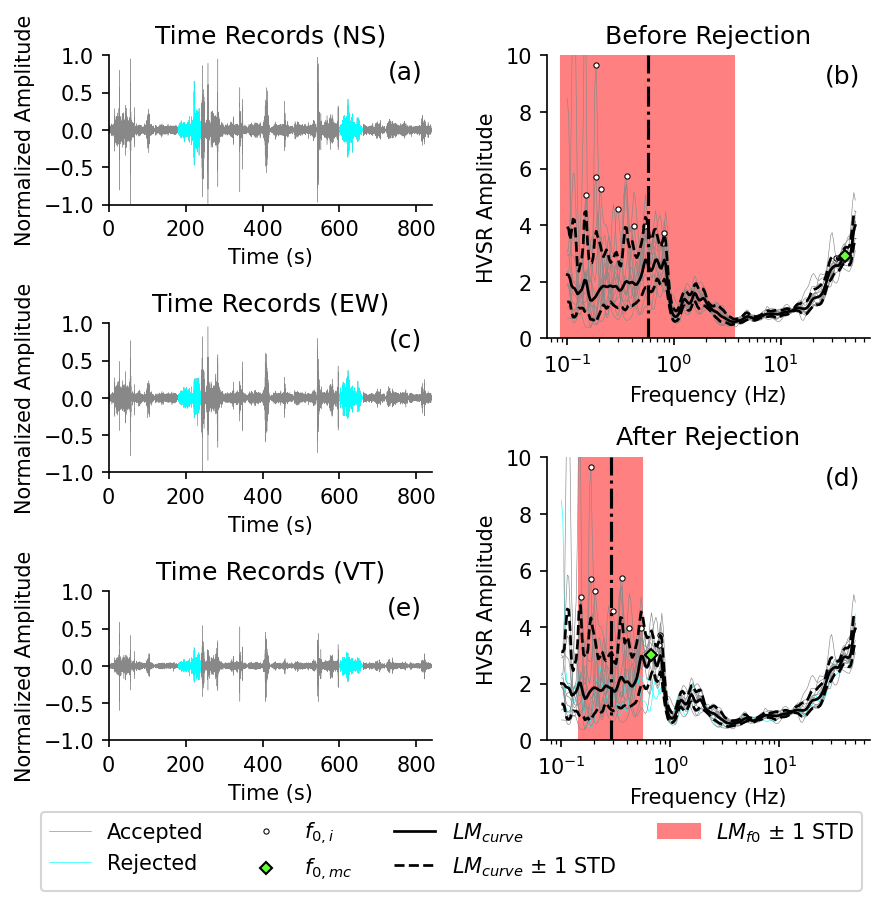

In [10]:
fig = plt.figure(figsize=(6,6), dpi=150)
gs = fig.add_gridspec(nrows=6,ncols=6)

ax0 = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[2:4, 0:3])
ax2 = fig.add_subplot(gs[4:6, 0:3])

if rejection_bool:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = fig.add_subplot(gs[3:6, 3:6])
else:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = False

start = time.time()
sensor = hvsrpy.Sensor3c(ns, ew, vt)
bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

individual_width = 0.3
median_width = 1.3
for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
    # Rejected Windows
    if title=="After Rejection":
        if len(hv.rejected_window_indices):
            label = "Rejected"
            for amp in hv.amp[hv.rejected_window_indices]:
                ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                label=None
            
    # Accepted Windows
    label="Accepted"
    for amp in hv.amp[hv.valid_window_indices]:
        ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                label = label if title=="Before Rejection" else "")
        label=None
    
    # Window Peaks
    ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
            marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
            label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")
    
    # Peak Mean Curve
    ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
            marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
            label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")
    
    # Mean Curve
    label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    # Mean +/- Curve
    label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3,
            label = "" if title=="Before Rejection" and rejection_bool else label)
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3)

    # f0 +/- STD
    if ymin is not None and ymax is not None:
        ax.set_ylim((ymin, ymax))
    label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
    _ymin, _ymax = ax.get_ylim()
    ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
    ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
            color = "#ff8080",
            label="" if title=="Before Rejection" and rejection_bool else label)
    ax.set_ylim((_ymin, _ymax))
    
    ax.set_xscale('log')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("HVSR Amplitude")
    if rejection_bool:
        if title=="Before Rejection":
            print("\nStatistics before rejection:")
            hv.print_stats(distribution_f0)
            c_iter = hv.reject_windows(n, max_iterations=max_iterations, 
                                       distribution_f0=distribution_f0, distribution_mc=distribution_mc)
        elif title=="After Rejection":
            fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

            print("\nAnalysis summary:")  
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                    data=[f"{windowlength}s", str(sensor.ns.nseries), f"{c_iter} of {max_iterations} allowed", str(sum(hv.rejected_window_indices))]))            
            print("\nStatistics after rejection:")
            hv.print_stats(distribution_f0)
    else:
        display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                         data=[f"{windowlength}s", str(sensor.ns.nseries)]))
        hv.print_stats(distribution_f0)
        fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
        break
    ax.set_title(title)

norm_factor = sensor.normalization_factor
for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
    ctime = timerecord.time
    amp = timerecord.amp/norm_factor
    ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
    ax.set_title(f"Time Records ({name})")
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(0, windowlength*timerecord.nseries)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

if rejection_bool:
    axs = [ax0, ax3, ax1, ax4, ax2]
else:
    axs = [ax0, ax3, ax1, ax2]
    
for ax, letter in zip(axs, list("abcde")):    
    ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)


fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
plt.show()

# Derive the sedimentary layer thickness assuming a single layer model

In [32]:
from ipywidgets import interact, Layout
import ipywidgets as widgets
@interact(Vs=widgets.FloatSlider(min=100.0, max=900.0, step=0.1, value=150.0,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          MAX=widgets.FloatSlider(min=0.001, max=10, step=0.01, value=20,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_hvsr_Vs(Vs, MAX, Save):
    
    Z= Vs/(4.0*MAX)
    plt.figure(figsize=(18,3))
    plt.plot(hv.frq, hv.mean_curve(distribution_mc), color='blue', label='V smooth')
    plt.grid()
    plt.ylabel('H/V')
    plt.xlabel('Frequency (Hz)')
    plt.title('Maximum HVSR for station:' + nm )
    plt.xlim(0,10)
    plt.axvline(x=MAX, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    print('Seismic station: ' + nm + '  -  MAX for HVSR: ', MAX ,'which correspond to a depth of: ', Z)
    if Save == True:
        print('\nSaving maximum of HVSR for station: ' + nm + ' at freq: ', MAX )
        results_file.write('%8.1f%14s%6.2f%14.1f%20s\n' % (MAX, '  -  ', Vs, Z ,STAT_NAME))
        results_file.flush()
    plt.figure()


interactive(children=(FloatSlider(value=150.0, continuous_update=False, description='Vs', layout=Layout(height…

# SESAME criteria compliance

In [13]:
reliability = utils.sesame_reliability(hv.meta["Window Length"], len(hv.valid_window_indices), hv.frq, hv.mean_curve(), hv.std_curve(), search_limits=(peak_f_lower, peak_f_upper), verbose=1)
clarity = utils.sesame_clarity(hv.frq, hv.mean_curve(), hv.std_curve(), hv.std_f0_frq(distribution="normal"), search_limits=(peak_f_lower, peak_f_upper), verbose=1)

Assessing SESAME (2004) reliability criteria ... 
  Criteria i): Pass
  Criteria ii): Pass
  Criteria iii): Pass
  The chosen peak PASSES the peak reliability criteria, with 3 of 3.
Assessing SESAME (2004) clarity criteria ... 
  Criteria i): Pass
  Criteria ii): Pass
  Criteria iii): Pass
  Criteria iv): Fail
  Criteria v): Fail
  Criteria vi): Pass
  The chosen peak FAILS the peak clarity criteria, with 4 of 6.


# Saving the results

In [14]:
fig.savefig(os.path.join(output, f"{nm}_HVSR.png"), dpi=300, bbox_inches='tight')

# 3D plot libraries import

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import cm

# Azimuth variability parameters input

In [16]:
# azimuthal_inverval defines the spacing in degrees between considerd azimuths.
azimuthal_interval = 15
azimuth = np.arange(0, 180, azimuthal_interval)

# ylimits of the HVSR figures.
ymin, ymax = 0, 15

# Azimuth variability plot

Elapsed Time: 3.57 seconds

Statistics after rejection considering azimuth:


Lognormal Median  \
Fundamental Site Frequency, f0,AZ              0.37   
Fundamental Site Period, T0,AZ                 2.69   

                                   Lognormal Standard Deviation  
Fundamental Site Frequency, f0,AZ                          1.11  
Fundamental Site Period, T0,AZ                             1.11

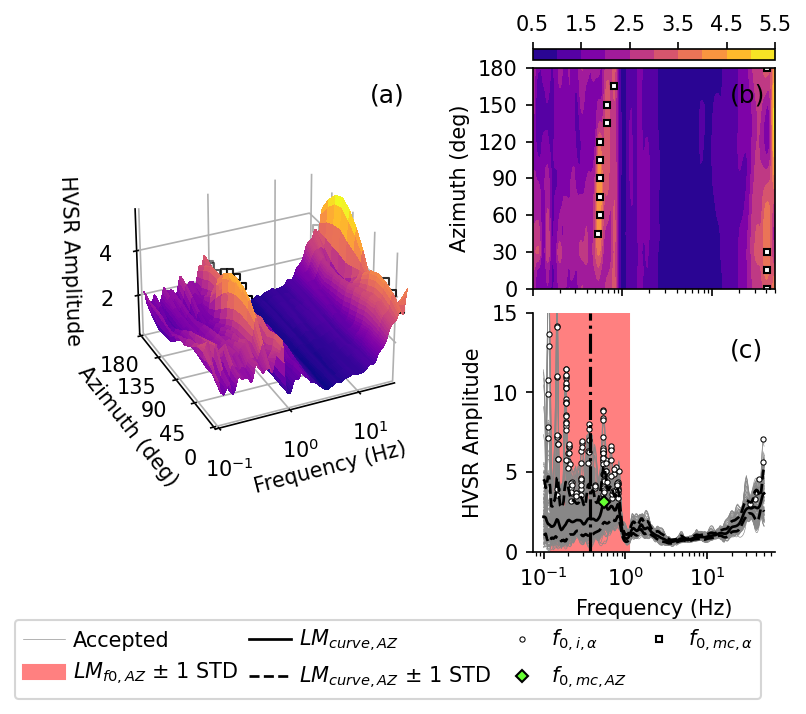

In [17]:
start = time.time()
sensor = hvsrpy.Sensor3c(ns, ew, vt)
bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, "multiple-azimuths", f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)

if rejection_bool:
    hv.reject_windows(n=n, max_iterations=max_iterations, distribution_f0=distribution_f0, distribution_mc=distribution_mc)

azimuths = [*hv.azimuths, 180.]
mesh_frq, mesh_azi = np.meshgrid(hv.frq, azimuths)
mesh_amp = hv.mean_curves(distribution=distribution_mc)
mesh_amp = np.vstack((mesh_amp, mesh_amp[0]))

end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

# Layout
fig = plt.figure(figsize=(6,5), dpi=150)
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.3, hspace=0.1, width_ratios=(1.2,0.8))
ax0 = fig.add_subplot(gs[0:2, 0:1], projection='3d')
ax1 = fig.add_subplot(gs[0:1, 1:2])
ax2 = fig.add_subplot(gs[1:2, 1:2])
fig.subplots_adjust(bottom=0.21) 

# Settings
individual_width = 0.3
median_width = 1.3

## 3D Median Curve
ax = ax0
ax.plot_surface(np.log10(mesh_frq), mesh_azi, mesh_amp, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
for coord in list("xyz"):
    getattr(ax, f"w_{coord}axis").set_pane_color((1, 1,1))    
ax.set_xticks(np.log10(np.array([0.01, 0.1, 1, 10, 100])))
ax.set_xticklabels(["$10^{"+str(x)+"}$" for x in range(-2, 3)])
ax.set_xlim(np.log10((0.1, 30)))
ax.view_init(elev=30, azim=245)
ax.dist=12
ax.set_yticks(np.arange(0,180+45, 45))
ax.set_ylim(0,180)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Azimuth (deg)")
ax.set_zlabel("HVSR Amplitude")
pfrqs, pamps = hv.mean_curves_peak(distribution=distribution_mc)
pfrqs = np.array([*pfrqs, pfrqs[0]])
pamps = np.array([*pamps, pamps[0]])
ax.scatter(np.log10(pfrqs), azimuths, pamps*1.01, marker="s", c="w", edgecolors="k", s=9)

## 2D Median Curve
ax = ax1
contour = ax.contourf(mesh_frq, mesh_azi, mesh_amp, cmap=cm.plasma, levels=10)
ax.set_xscale("log")
ax.set_xticklabels([])
ax.set_ylabel("Azimuth (deg)")
ax.set_yticks(np.arange(0,180+30, 30))
ax.set_ylim(0,180)
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
fig.colorbar(contour, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")

ax.plot(pfrqs, azimuths, marker="s", color="w", linestyle="", markersize=3, markeredgecolor="k",
        label=r"$f_{0,mc,\alpha}$")

## 2D Median Curve
ax = ax2

# Accepted Windows
label="Accepted"
for amps in hv.amp:
    for amp in amps:
        ax.plot(hv.frq, amp, color="#888888", linewidth=individual_width, zorder=2, label=label)
        label=None

# Mean Curve
label = r"$LM_{curve,AZ}$" if distribution_mc=="lognormal" else r"$Mean_{curve,AZ}$"
ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', label=label, linewidth=median_width, zorder=4)

# Mean +/- Curve
label = r"$LM_{curve,AZ}$"+" ± 1 STD" if distribution_mc=="lognormal" else r"$Mean_{curve,AZ}$"+" ± 1 STD"
ax.plot(hv.frq, hv.nstd_curve(-1, distribution=distribution_mc), color="k", linestyle="--",
        linewidth=median_width, zorder=4, label=label)
ax.plot(hv.frq, hv.nstd_curve(+1, distribution=distribution_mc), color="k", linestyle="--",
        linewidth=median_width, zorder=4)

# Window Peaks
label = r"$f_{0,i,\alpha}$"
for frq, amp in zip(hv.peak_frq, hv.peak_amp):
    ax.plot(frq, amp, linestyle="", zorder=3, marker='o', markersize=2.5, markerfacecolor="#ffffff",
            markeredgewidth=0.5, markeredgecolor='k', label=label)
    label=None

# Peak Mean Curve
ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=5,
        marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
        label = r"$f_{0,mc,AZ}$")

# f0,az
if ymin is not None and ymax is not None:
        ax.set_ylim((ymin, ymax))
label = r"$LM_{f0,AZ}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean "+r"$f_{0,AZ}$"+" ± 1 STD"
_ymin, _ymax = ax.get_ylim()
ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [ymin, ymax], linestyle="-.", color="#000000", zorder=6)
ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
        color = "#ff8080", label=label, zorder=1)
ax.set_ylim((_ymin, _ymax))

# Limits and labels
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("HVSR Amplitude")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
    
# Lettering
xs, ys = [0.45, 0.85, 0.85], [0.81, 0.81, 0.47]  
for x, y, letter in zip(xs, ys, list("abc")):
    fig.text(x, y, f"({letter})", fontsize=12)
    
# Legend
handles, labels = [], []
for ax in [ax2, ax1, ax0]:
        _handles, _labels = ax.get_legend_handles_labels()
        handles += _handles
        labels += _labels
new_handles, new_labels = [], []
for index in [0, 5, 1, 2, 3, 4, 6]:
    new_handles.append(handles[index])
    new_labels.append(labels[index])
fig.legend(new_handles, new_labels, loc="lower center", bbox_to_anchor=(0.47, 0), ncol=4,
           columnspacing=0.5, handletextpad=0.4)

# Print stats
print("\nStatistics after rejection considering azimuth:")
hv.print_stats(distribution_f0)

plt.show()    

# Saving the results

In [18]:
fig.savefig(os.path.join(output, f"{nm}_HVSR_azm.png"), dpi=300, bbox_inches='tight')